# Network Interpretability | proximity-quadrotor-learning

https://github.com/idsia-robotics/proximity-quadrotor-learning

## Settings

### Imports

In [ ]:
# %tensorflow_version 1.x
import tensorflow as tf

# when importing keras, please notice:
#   https://stackoverflow.com/a/57298275/10866825
#   https://www.pyimagesearch.com/2019/10/21/keras-vs-tf-keras-whats-the-difference-in-tensorflow-2-0/

from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model, to_categorical
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint

# !pip install resnet
# import resnet as kr

import numpy as np
import pandas as pd
import sklearn as sk
import sklearn.metrics

import math
import os
import random
import sys
from datetime import datetime
from PIL import Image

import matplotlib.pyplot as plt
%matplotlib inline

### Paths

In [ ]:
try:
  import google.colab
  IN_COLAB = True
  from google.colab import drive
  drive.mount('/content/drive')
  models_folder = '/content/drive/My Drive/_ USI/_ THESIS/proximity-quadrotor-learning/trained-models/'
  pickles_folder = '/content/drive/My Drive/_ USI/_ THESIS/proximity-quadrotor-learning/dataset/Whole Dataset/pickles/'
  new_models_folder = '/content/drive/My Drive/_ USI/_ THESIS/proximity-quadrotor-learning/marco-test/new-models/'
  visualization_folder = '/content/drive/My Drive/_ USI/_ THESIS/proximity-quadrotor-learning/marco-test/visualization/'
  videos_folder = '/content/video/'
except:
  # this file goes into 'proximity-quadrotor-learning/marco-test' folder
  IN_COLAB = False
  models_folder = '../trained-models/' # Dario's original trained models (https://drive.switch.ch/index.php/s/Idsyf8WIwQpvRMF)
  pickles_folder = '../dataset/Whole Dataset/pickles/' # Dario's original dataset (https://drive.switch.ch/index.php/s/8clDQNH645ZjWDD)
  new_models_folder = 'new-models/'
  visualization_folder = 'visualization/'
  videos_folder = 'video/'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
chosen_model = 1
model_path = models_folder + 'v' + str(chosen_model) + '_model_train_size_50000_rep_1.h5'
pickle_train_path = pickles_folder + 'version' + str(chosen_model) + '/train.pickle'
pickle_test_path = pickles_folder + 'version' + str(chosen_model) + '/test.pickle'

### Utils

In [ ]:
image_height = 60
image_width = 108
variables_names = ['x_pred', 'y_pred', 'z_pred', 'yaw_pred', 'x_class', 'y_class', 'z_class', 'w_class']

def compute_metrics(y_test, y_pred):
    """
        compute r2 and rmse
    Args:
        y_test: set of labels
        y_pred: set of predictions

    Returns:
        scores
    """
    rmse_score = []
    r2_score = []
    for i in range(4):
        rmse_score.append(np.math.sqrt(sk.metrics.mean_squared_error(y_test[:, i], y_pred[i])))
        r2_score.append(sk.metrics.r2_score(y_test[:, i], y_pred[i]))
    return r2_score, rmse_score

## Dario's Model

In [ ]:
old_model = tf.keras.models.load_model(model_path)
old_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
image_input (InputLayer)        [(None, 60, 108, 3)] 0                                            
__________________________________________________________________________________________________
model_1 (Model)                 (None, 1, 1, 256)    1235200     image_input[0][0]                
__________________________________________________________________________________________________
flatten_1 (Flatten)             (None, 256)          0           model_1[1][0]                    
__________________________________________________________________________________________________
1_dense (Dense)                 (None, 256)          65792       flatten_1[0][0]                  
____________________________________________________________________________________________

In [ ]:
print('RES-NET')
old_model.get_layer("model_1").summary()

RES-NET
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 60, 108, 3)] 0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 30, 54, 64)   9472        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 30, 54, 64)   256         conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 30, 54, 64)   0           batch_normalization_1[0][0]      
____________________________________________________________________________________

## Dataset

Here, **regression variables** in the ground truth are used to retrieve **classification variables** (added to the dataset `y`) by discretizing continous values accordingly to arbitrary defined bin intervals. Train set size is reduced to avoid overloads.

In [ ]:
train_set = pd.read_pickle(pickle_train_path).values
train_set = train_set[:len(train_set)//2] # reducing dataset size
print('train shape: ' + str(train_set.shape))

train shape: (31863, 3)


In [ ]:
x_train = 255 - train_set[:, 0]
x_train = np.vstack(x_train[:]).astype(np.float32)
x_train = np.reshape(x_train, (-1, image_height, image_width, 3))

y_train = train_set[:, 1]
y_train = np.vstack(y_train[:]).astype(np.float32)

visual_odom = train_set[:, 2]
visual_odom = np.vstack(visual_odom[:]).astype(np.float32)

print('x_train shape: ' + str(x_train.shape))
print('y_train shape: ' + str(y_train.shape))
print('visual_odom shape: ' + str(visual_odom.shape))

x_train shape: (31863, 60, 108, 3)
y_train shape: (31863, 4)
visual_odom shape: (31863, 2)


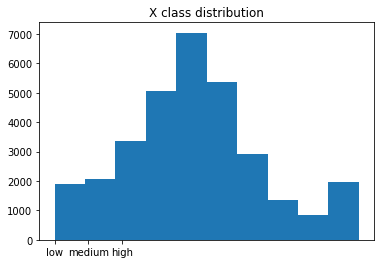

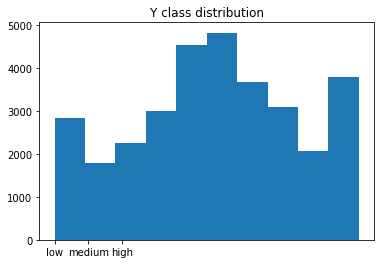

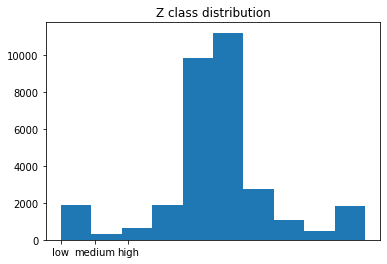

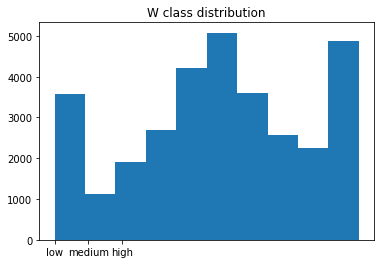

regression variables 	 (4, 31863)
classification variables 	 (4, 31863, 10)

Note that np.shape(y_train_feed) cannot be computed because elements have different shapes:
total train variables 		 8
single train regression var 	 (31863,)
single train multi-class var 	 (31863, 10)


In [ ]:
var_labels = ['low','medium','high']


# ---- X

var_x_values = y_train[:,0]
var_x_bins = np.array([-np.inf, 1.4, 1.6, np.inf])
var_x_assign = np.digitize(var_x_values, np.hstack([-np.inf, np.arange(start = 1.1, stop = 1.91, step = 0.1), np.inf])) - 1
plt.hist(var_x_assign)
plt.xticks(range(3), var_labels)
plt.title('X class distribution')
plt.show()

# ---- Y

var_y_values = y_train[:,1]
var_y_bins = np.array([-np.inf, -0.15, 0.15, np.inf])
var_y_assign = np.digitize(var_y_values, np.hstack([-np.inf, np.arange(start = -0.4, stop = 0.41, step = 0.1), np.inf])) - 1
plt.hist(var_y_assign)
plt.xticks(range(3), var_labels)
plt.title('Y class distribution')
plt.show()

# ---- Z

var_z_values = y_train[:,2]
var_z_bins = np.array([-np.inf, -0.05, 0.05, np.inf])
var_z_assign = np.digitize(var_z_values, np.hstack([-np.inf, np.arange(start = -0.2, stop = 0.21, step = 0.05), np.inf])) - 1
plt.hist(var_z_assign)
plt.xticks(range(3), var_labels)
plt.title('Z class distribution')
plt.show()

# ---- W

var_w_values = y_train[:,3]
var_w_bins = np.array([-np.inf, -0.2, 0.2, np.inf])
var_w_assign = np.digitize(var_w_values, np.hstack([-np.inf, np.arange(start = -0.6, stop = 0.61, step = 0.15), np.inf])) - 1
plt.hist(var_w_assign)
plt.xticks(range(3), var_labels)
plt.title('W class distribution')
plt.show()


# # ---- Values renaming

# var_x_assign = [var_labels[i] for i in var_x_assign]
# var_y_assign = [var_labels[i] for i in var_y_assign]
# var_z_assign = [var_labels[i] for i in var_z_assign]
# var_w_assign = [var_labels[i] for i in var_w_assign]




# ---- Train set Y modification

stack = np.squeeze(np.dstack((var_x_assign, var_y_assign, var_z_assign, var_w_assign)))
y_train = np.append(y_train, stack, axis=1)

# regression variables
ytr = np.transpose(y_train[:,0:4])
print('regression variables \t', np.shape(ytr))

# classification variables
cat_train = to_categorical(y_train[:,4:8])
ytc = np.transpose(cat_train, (1, 0, 2))
print('classification variables \t', np.shape(ytc))


x_train_feed = x_train
y_train_feed = [ytr[0], ytr[1], ytr[2], ytr[3], ytc[0], ytc[1], ytc[2], ytc[3]]
print()
print('Note that np.shape(y_train_feed) cannot be computed because elements have different shapes:') 
print('total train variables \t\t', len(y_train_feed))
print('single train regression var \t', np.shape(y_train_feed[0]))
print('single train multi-class var \t', np.shape(y_train_feed[4]))

## Model

Most of the libraries used for Network Intrpretability, such as `tf-explain` or `keras-vis`, give [this issue](https://github.com/sicara/tf-explain/issues/116) if run with nested models.  
That is why we choose to reconstruct the Dario's model without nesting.

Following code can build up a network which has both regression (originals ones) and classification variables, or just the latter ones. Also, if `classification_only == True` it is possibile to specify a value for variable `var_index`, so that the network will be composed by just one output (4: `x`, 5: `y`, 6: `z`, 7: `w`) - this is useful for better visualizing Network Interpretability techniques. If `var_index == None`, then all classification variables are being used.

In [ ]:
classification_only = True
var_index = None if not classification_only else None # set None if you want all classification vars

### Construction

Reconstructing model by scratch following Dario's architecture.

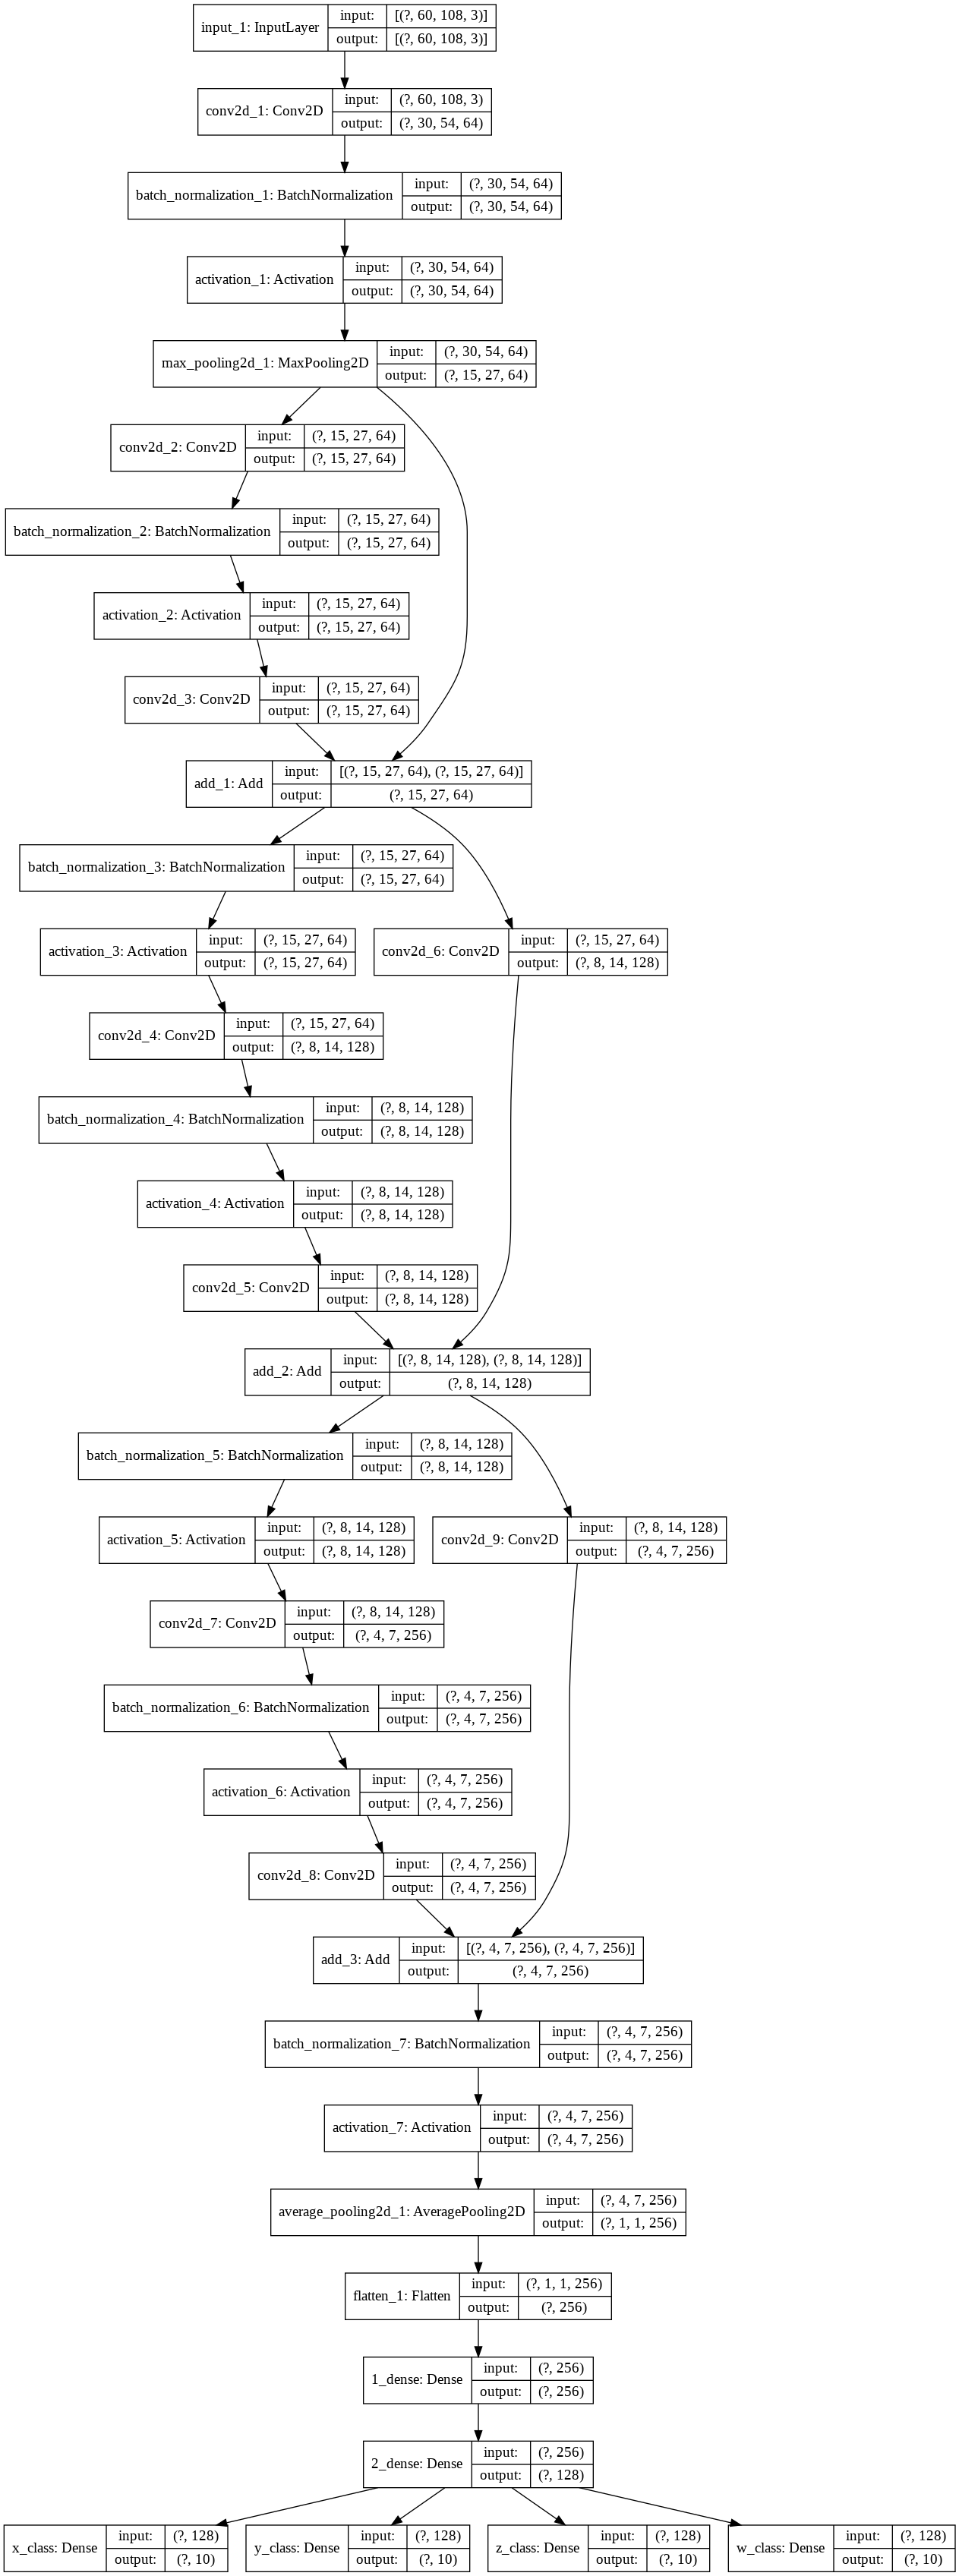

In [ ]:
input_img = Input(shape=(60, 108, 3), name = 'input_1')

# start resnet
conv_1 = Conv2D(64, kernel_size=(7,7), strides=(2,2), padding='same', name = 'conv2d_1')(input_img)
batch_1 = BatchNormalization(name = 'batch_normalization_1')(conv_1)
activ_1 = Activation('relu', name = 'activation_1')(batch_1)
pool_1 = MaxPooling2D(pool_size=(3, 3), strides=(2,2), padding='same', name = 'max_pooling2d_1')(activ_1)

# block 1
conv_2 = Conv2D(64, kernel_size=(3,3), strides=(1,1), padding='same', name = 'conv2d_2')(pool_1)
batch_2 = BatchNormalization(name = 'batch_normalization_2')(conv_2)
activ_2 = Activation('relu', name = 'activation_2')(batch_2)
conv_3 = Conv2D(64, kernel_size=(3,3), strides=(1,1), padding='same', name = 'conv2d_3')(activ_2)
add_1 = Add(name = 'add_1')([conv_3, pool_1])

# block 2
batch_3 = BatchNormalization(name = 'batch_normalization_3')(add_1)
activ_3 = Activation('relu', name = 'activation_3')(batch_3)
conv_4 = Conv2D(128, kernel_size=(3,3), strides=(2,2), padding='same', name = 'conv2d_4')(activ_3)
batch_4 = BatchNormalization(name = 'batch_normalization_4')(conv_4)
activ_4 = Activation('relu', name = 'activation_4')(batch_4)
conv_5 = Conv2D(128, kernel_size=(3,3), strides=(1,1), padding='same', name = 'conv2d_5')(activ_4)
conv_6 = Conv2D(128, kernel_size=(1,1), strides=(2,2), padding='valid', name = 'conv2d_6')(add_1)
add_2 = Add(name = 'add_2')([conv_5, conv_6])

# block
batch_5 = BatchNormalization(name = 'batch_normalization_5')(add_2)
activ_5 = Activation('relu', name = 'activation_5')(batch_5)
conv_7 = Conv2D(256, kernel_size=(3,3), strides=(2,2), padding='same', name = 'conv2d_7')(activ_5)
batch_6 = BatchNormalization(name = 'batch_normalization_6')(conv_7)
activ_6 = Activation('relu', name = 'activation_6')(batch_6)
conv_8 = Conv2D(256, kernel_size=(3,3), strides=(1,1), padding='same', name = 'conv2d_8')(activ_6)
conv_9 = Conv2D(256, kernel_size=(1,1), strides=(2,2), padding='valid', name = 'conv2d_9')(add_2)
add_3 = Add(name = 'add_3')([conv_8, conv_9])

# end resnet
batch_7 = BatchNormalization(name = 'batch_normalization_7')(add_3)
activ_7 = Activation('relu', name = 'activation_7')(batch_7)
pool_2 = AveragePooling2D(pool_size = (4, 7), strides = (1, 1), padding = 'valid', name = 'average_pooling2d_1')(activ_7)

# dense
flatten_1 = Flatten(name = 'flatten_1')(pool_2)
dense_1 = (Dense(256, activation='relu', name="1_dense"))(flatten_1)
dense_2 = (Dense(128, activation='relu', name="2_dense"))(dense_1)

# targets
y_0 = (Dense(1, activation='linear', name=variables_names[0]))(dense_2)
y_1 = (Dense(1, activation='linear', name=variables_names[1]))(dense_2)
y_2 = (Dense(1, activation='linear', name=variables_names[2]))(dense_2)
y_3 = (Dense(1, activation='linear', name=variables_names[3]))(dense_2)
y_4 = (Dense(np.shape(y_train_feed[4])[1], activation='softmax', name=variables_names[4]))(dense_2)
y_5 = (Dense(np.shape(y_train_feed[5])[1], activation='softmax', name=variables_names[5]))(dense_2)
y_6 = (Dense(np.shape(y_train_feed[6])[1], activation='softmax', name=variables_names[6]))(dense_2)
y_7 = (Dense(np.shape(y_train_feed[7])[1], activation='softmax', name=variables_names[7]))(dense_2)



if classification_only:
  outputs = [y_4, y_5, y_6, y_7]
  if var_index != None:
    outputs = outputs[var_index - 4]
else:
  outputs = [y_0, y_1, y_2, y_3, y_4, y_5, y_6, y_7]


# MODEL
flat_model = Model(inputs = input_img, outputs = outputs)

tf.keras.utils.plot_model(flat_model, show_shapes = True, expand_nested = True)

Restoring weights from Dario's model.

In [ ]:
old_model = tf.keras.models.load_model(model_path)

layers_counter = 0

if classification_only:
  copy_until = -4 # avoids to copy regression variables weights
  non_trainable_until = -len(outputs) if isinstance(outputs, list) else -1 # only outputs will be trainable
else:
  copy_until = None # all weights are restored
  non_trainable_until = -4  # only classification variables (the last four) will be trainable


for layer in old_model.layers[2:copy_until]: # starts at 2 for skipping inputs and nested model
  flat_model.get_layer(layer.name).set_weights(layer.get_weights())
  layers_counter += 1

for layer in old_model.get_layer('model_1').layers: # nested model weights
  flat_model.get_layer(layer.name).set_weights(layer.get_weights())
  layers_counter += 1


# assert(len(flat_model.layers) == layers_counter + 4) 


# Freeze all the layers before the `non_trainable_until` layer
for layer in flat_model.layers[:non_trainable_until]:
  layer.trainable =  False

flat_model.summary()
print('Please note that only output layers are now trainable.')

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 60, 108, 3)] 0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 30, 54, 64)   9472        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 30, 54, 64)   256         conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 30, 54, 64)   0           batch_normalization_1[0][0]      
____________________________________________________________________________________________

### Training

Epoch 1/20
399/399 [==============================] - 5s 13ms/step - loss: 7.7953 - x_class_loss: 2.1068 - y_class_loss: 1.9727 - z_class_loss: 1.7934 - w_class_loss: 1.9224 - x_class_accuracy: 0.2092 - y_class_accuracy: 0.3231 - z_class_accuracy: 0.3377 - w_class_accuracy: 0.3750 - val_loss: 7.0751 - val_x_class_loss: 1.9691 - val_y_class_loss: 1.7940 - val_z_class_loss: 1.6136 - val_w_class_loss: 1.6985 - val_x_class_accuracy: 0.2675 - val_y_class_accuracy: 0.3449 - val_z_class_accuracy: 0.3399 - val_w_class_accuracy: 0.4376 - lr: 0.0010
Epoch 2/20
399/399 [==============================] - 5s 13ms/step - loss: 6.7503 - x_class_loss: 1.9555 - y_class_loss: 1.6797 - z_class_loss: 1.5367 - w_class_loss: 1.5784 - x_class_accuracy: 0.2707 - y_class_accuracy: 0.4169 - z_class_accuracy: 0.4057 - w_class_accuracy: 0.4501 - val_loss: 6.4744 - val_x_class_loss: 1.8860 - val_y_class_loss: 1.5946 - val_z_class_loss: 1.4909 - val_w_class_loss: 1.5029 - val_x_class_accuracy: 0.3096 - val_y_class_

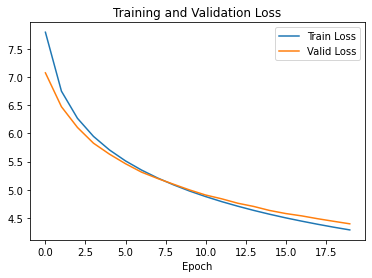

In [ ]:
if classification_only:
  loss = 'categorical_crossentropy'
  metrics = 'accuracy'
  if var_index == None:
    yyy = y_train_feed[4:8]
  else:
    yyy = y_train_feed[var_index]
else:
  loss = list(np.array([['mean_absolute_error'] * 4, ['categorical_crossentropy'] * 4]).flatten())
  metrics = ['mse', 'accuracy']
  yyy = y_train_feed


# --- Model settings

flat_model.compile(loss=loss,
              metrics=metrics,
              optimizer='adam')

lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1), cooldown=1, patience=3, min_lr=0.1e-6)
early_stop = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=10, verbose=1)

callbacks = [lr_reducer, early_stop]


# --- Training

history = flat_model.fit(
    x = x_train_feed,
    y = yyy,
    batch_size = 64,
    epochs = 20,
    validation_split = 0.2,
    callbacks = callbacks,
    shuffle = True
)

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Valid Loss')
plt.legend(loc='upper right')
plt.xlabel('Epoch')
plt.title('Training and Validation Loss')
plt.show()

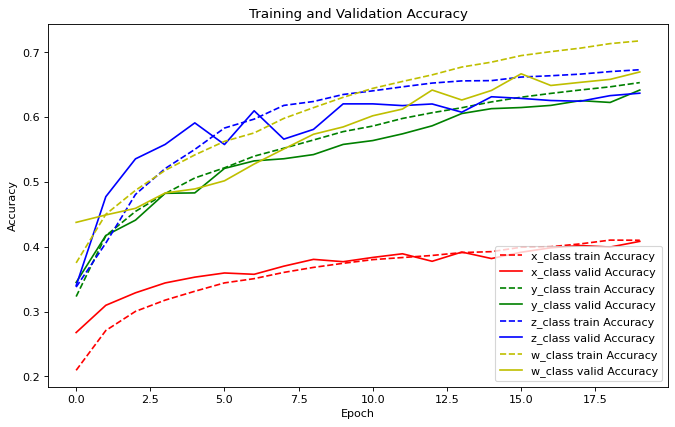

In [ ]:
if var_index == None: # all variables metrics
  plt.figure(num=None, figsize=(10, 6), dpi=80)
  plt.plot(history.history['x_class_accuracy'], 'r--', label='x_class train Accuracy')
  plt.plot(history.history['val_x_class_accuracy'], 'r', label='x_class valid Accuracy')
  plt.plot(history.history['y_class_accuracy'], 'g--', label='y_class train Accuracy')
  plt.plot(history.history['val_y_class_accuracy'], 'g', label='y_class valid Accuracy')
  plt.plot(history.history['z_class_accuracy'], 'b--', label='z_class train Accuracy')
  plt.plot(history.history['val_z_class_accuracy'], 'b', label='z_class valid Accuracy')
  plt.plot(history.history['w_class_accuracy'], 'y--', label='w_class train Accuracy')
  plt.plot(history.history['val_w_class_accuracy'], 'y', label='w_class valid Accuracy')
  plt.legend(loc='lower right')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.title('Training and Validation Accuracy')
  plt.show()
else: # single variable metrics
  plt.figure(num=None, figsize=(10, 6), dpi=80)
  plt.plot(history.history['accuracy'], 'r--', label=variables_names[var_index] + ' train Accuracy')
  plt.plot(history.history['val_accuracy'], 'r', label=variables_names[var_index] + ' valid Accuracy')
  plt.legend(loc='lower right')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.title('Training and Validation Accuracy')
  plt.show()

### Demo

input shape (None, 60, 108, 3)
batch shape (1, 60, 108, 3)

actual regr [ 1.53324652 -0.07824928  0.01195645 -0.55631542]
actual class [5. 4. 5. 1.]

pred class [5 3 5 0]

network prediction


[array([[0.0068716 , 0.02468614, 0.0743207 , 0.14314042, 0.25296524,
         0.28000715, 0.1397271 , 0.03453718, 0.02598523, 0.01775927]],
       dtype=float32),
 array([[1.40948165e-02, 9.83516946e-02, 1.83781981e-01, 2.97501832e-01,
         2.93954939e-01, 9.46688578e-02, 1.34562254e-02, 3.07958573e-03,
         1.02908735e-03, 8.10005804e-05]], dtype=float32),
 array([[0.00183503, 0.00624468, 0.01526502, 0.05083299, 0.30230513,
         0.49319687, 0.08721813, 0.02509107, 0.01086151, 0.00714957]],
       dtype=float32),
 array([[5.03109694e-01, 2.58559287e-01, 1.83783635e-01, 4.40291204e-02,
         1.00127645e-02, 4.69324936e-04, 2.72734469e-05, 7.54357552e-06,
         1.27487010e-06, 3.65412980e-08]], dtype=float32)]

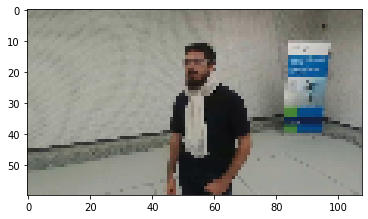

In [ ]:
frame_idx = np.random.randint(0, x_train.shape[0])
batch = np.array([x_train[frame_idx]]) # input image

print('input shape', flat_model.input_shape)
print('batch shape', batch.shape)

plt.imshow(train_set[frame_idx,0])

print()
print('actual regr', y_train[frame_idx,0:4])
print('actual class', y_train[frame_idx,4:8])
# print('actual class', [var_labels[int(i)] for i in y_train[frame_idx,4:8]])

prediction = flat_model.predict(batch) # model prediction

print()
if classification_only:
  axis = 2 if var_index == None else 1
  prediction_class_argmax = np.argmax(prediction, axis=axis).flatten()
else:
  prediction_regr = np.array(prediction[0:4]).flatten()
  print('pred regr', prediction_regr)
  prediction_class_argmax = np.argmax(prediction[4:8], axis=2).flatten()


print('pred class', prediction_class_argmax)
# print('pred class', [var_labels[int(i)] for i in prediction_class_argmax] if var_index == None else var_labels[int(prediction_class_argmax)])


print()
print('network prediction')
prediction

In [ ]:
variable_to_show = 0 if var_index == None else var_index # 0: x, 1: y, 2: z, 3: w
offset = 0 if classification_only else 4

if var_index == None:
  class_idxs_sorted = np.argsort(prediction[offset + variable_to_show].flatten())[::-1]
else:
  class_idxs_sorted = np.argsort(prediction.flatten())[::-1]

print('Predictions for variable', variables_names[offset + variable_to_show])
for i, idx in enumerate(class_idxs_sorted[:3]):
  cur_pred = prediction[offset + variable_to_show][0, idx] if var_index == None else prediction[0, idx]
  print("Top {} predicted class:     Pr(Class={:6} [index={}]) = {:5.3f}".format(
          i + 1, var_labels[idx], idx, cur_pred))

Predictions for variable x_pred


IndexError: ignored

### Saving

In [ ]:
import time
timestr = time.strftime("%Y%m%d_%H%M%S")

model_name = '_10bins_flatmodel_(' + ('all_var' if var_index == None else variables_names[var_index]) + ')_'
notes = '_()'

new_model_namepath = new_models_folder + 'v' + str(chosen_model) + model_name + timestr + notes
print(new_model_namepath)

# plot_model(flat_model, to_file = new_model_namepath + '.png', show_shapes = True, expand_nested = False)
# flat_model.save(new_model_namepath + '.h5')

/content/drive/My Drive/_ USI/_ THESIS/proximity-quadrotor-learning/marco-test/new-models/v1_10bins_flatmodel_(all_var)_20200515_122322_()


## Network Interpretability

Most of the libraries, such as `tf-explain` or `keras-vis`, give [this issue](https://github.com/sicara/tf-explain/issues/116) if run with nested models.  
That is why we choose to reconstruct the model without nesting.

We tried [keras-vis](https://github.com/raghakot/keras-vis) with [this tutorial](https://fairyonice.github.io/Grad-CAM-with-keras-vis.html), but `keras-vis` directly uses `keras` instead of `tensorflow.keras`, then it is not compatible with our model and we get [this error](https://stackoverflow.com/questions/58878421/unexpected-keyword-argument-ragged-in-keras) if trying to use it. See also [this](https://stackoverflow.com/a/57298275/10866825) and [this](https://www.pyimagesearch.com/2019/10/21/keras-vs-tf-keras-whats-the-difference-in-tensorflow-2-0/ ) for information about the difference between `keras` and `tensorflow.keras`. We instead rely on [tf-keras-vis](https://github.com/keisen/tf-keras-vis) as suggested [here](https://github.com/raghakot/keras-vis/issues/160#issuecomment-567930344), following [this GradCAM tutorial](https://github.com/keisen/tf-keras-vis/blob/master/examples/attentions.ipynb).

### Settings

In [ ]:
!pip install tf-keras-vis
from tf_keras_vis.utils import print_gpus
print_gpus()

1 Physical GPUs, 1 Logical GPU


In [ ]:
# Define modifier to replace the softmax function of classification layers to a linear function.
def model_modifier(m):
  if var_index == None:
    m.get_layer('x_class').activation = tf.keras.activations.linear
    m.get_layer('y_class').activation = tf.keras.activations.linear
    m.get_layer('z_class').activation = tf.keras.activations.linear
    m.get_layer('w_class').activation = tf.keras.activations.linear
  else: # single variable
    m.get_layer(variables_names[var_index]).activation = tf.keras.activations.linear

# Define loss functions
loss_low    = lambda output: K.mean(output[:,var_labels.index('low')])    if output.shape[1] == 3 else K.mean(output)
loss_medium = lambda output: K.mean(output[:,var_labels.index('medium')]) if output.shape[1] == 3 else K.mean(output)
loss_high   = lambda output: K.mean(output[:,var_labels.index('high')])   if output.shape[1] == 3 else K.mean(output)
loss_total  = lambda output: K.mean(output)

#### Vanilla Saliency & Smoothgrad

Saliency generate the saliency map that appears input regions that a change in the input value contribute the output value.

> Note: The softmax activation function which is applied to model's last layer may obstruct generating shape attention images, so that you need to replace the function to a linear function using model_modifier.

However, **Vanilla Saliency** map is too noisy, so that let's remove noise in saliency map using SmoothGrad! **SmoothGrad** is a algorithm that reduce noise including saliency map by adding noise to input image. You can control it through the parameter `smooth_samples`.



In [ ]:
from tf_keras_vis.saliency import Saliency
from tf_keras_vis.utils import normalize


# Generate saliency map with smoothing that reduce noise by adding noise
def perform_saliency(saliency_obj, title, loss, smooth=0):
  
  saliency_map = saliency_obj(loss, vis_x, smooth_samples=smooth)
  saliency_map = normalize(saliency_map)
  f, ax = get_subplots()
  f.suptitle(title) # y moves title up
  
  for i in range(len(saliency_map)):
    if(images_number == 1 and ncols == 1):
      cell = ax
    elif(nrows == 1):
      cell = ax[i]
    else:
      cell = ax[i//ncols, i%ncols]

    # if var_index == None:
    #   aa = str([var_labels[int(j)] for j in y_train[vis_idx[i],4:8]])
    #   pp = str([var_labels[int(j)] for j in img_class_pred[i]])
    # else:
    #   aa = var_labels[int(y_train[vis_idx[i],var_index])]
    #   pp = var_labels[img_class_pred[i]]
    # cell.set_title('A: ' + aa + '\nP: ' + pp)
    
    cell.imshow(vis_img[i])
    cell.imshow(saliency_map[i], cmap='jet', alpha=0.3)

#### GradCAM
Saliency is one of useful way of visualizing attention that appears input regions that a change in the input value contribute the output value. GradCAM is another way of visualizing attention over input. Instead of using gradients with respect to model outputs, it uses penultimate (pre Dense layer) Conv layer output.


In [ ]:
from matplotlib import cm
from tf_keras_vis.gradcam import Gradcam


# Generate GradCAM heatmaps
def perform_gradcam(gradcam_obj, title, loss):
  
  cam = gradcam_obj(loss, vis_x)
  cam = normalize(cam)

  f, ax = get_subplots()
  f.suptitle(title) # y moves title up
  for i in range(len(cam)):
    if(images_number == 1 and ncols == 1):
      cell = ax
    elif(nrows == 1):
      cell = ax[i]
    else:
      cell = ax[i//ncols, i%ncols]

    # if var_index == None:
    #   aa = str([var_labels[int(j)] for j in y_train[vis_idx[i],4:8]])
    #   pp = str([var_labels[int(j)] for j in img_class_pred[i]])
    # else:
    #   aa = var_labels[int(y_train[vis_idx[i],var_index])]
    #   pp = var_labels[img_class_pred[i]]
    # cell.set_title('A: ' + aa + '\nP: ' + pp)
    
    heatmap = np.uint8(cm.jet(cam[i])[..., :3] * 255)
    cell.imshow(vis_img[i])
    cell.imshow(heatmap, cmap='jet', alpha=0.3)

### Model selection

In [ ]:
# vis_model = flat_model
# classification_only = classification_only
# var_index = var_index

vis_model = tf.keras.models.load_model(new_models_folder + 'v1_10bins_flatmodel_(all_var)_20200515_122322_().h5' )
vis_model.summary()
classification_only = True # set accordingly if loaded model only has classification variables
var_index = None if not classification_only else None # set accordingly if loaded model only has one variable

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 60, 108, 3)] 0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 30, 54, 64)   9472        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 30, 54, 64)   256         conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 30, 54, 64)   0           batch_normalization_1[0][0]      
____________________________________________________________________________________________

### Data selection

Act on `images_number` and `ncols` to choose how you want to visualize images.

selected indexes:  [27189] 



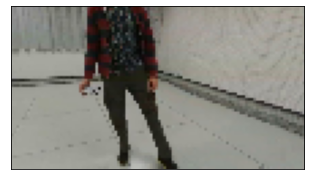

In [ ]:
images_number = 1
ncols = 1
nrows = np.math.ceil(images_number/ncols)
max_random = x_train_feed.shape[0]


def get_subplots():
  return plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, nrows * 3), subplot_kw={'xticks': [], 'yticks': []})


# vis_idx = np.random.randint(0, max_random, images_number) # random selection
vis_idx = [27189]
print('selected indexes: ', vis_idx, '\n')
vis_img = np.array(train_set[vis_idx, 0].tolist()) # images
vis_x = np.array(x_train_feed[vis_idx].tolist()) # model inputs

vis_prediction = vis_model.predict(vis_x) # model prediction
if not classification_only:
  vvv = vis_prediction[4:8]
else:
  vvv = vis_prediction


# `img_class_pred` will contain top 1 prediction for all images and variables
axis = 2 if var_index == None else 1
img_class_pred = np.argmax(vvv, axis=axis).T # rows=images, cols=variables


# images visualization
f, ax = get_subplots()
for i in range(images_number):
  if(images_number == 1 and ncols == 1):
    cell = ax
  elif(nrows == 1):
    cell = ax[i]
  else:
    cell = ax[i//ncols, i%ncols]

  # if var_index == None:
  #   aa = str([var_labels[int(j)] for j in y_train[vis_idx[i],4:8]])
  #   pp = str([var_labels[int(j)] for j in img_class_pred[i]])
  # else: # single variable
  #   aa = var_labels[int(y_train[vis_idx[i],var_index])]
  #   pp = var_labels[img_class_pred[i]]
  
  # cell.set_title('A: ' + aa + '\nP: ' + pp)
  cell.imshow(vis_img[i])

### Results

Here the 3 methods are applied to selected images.

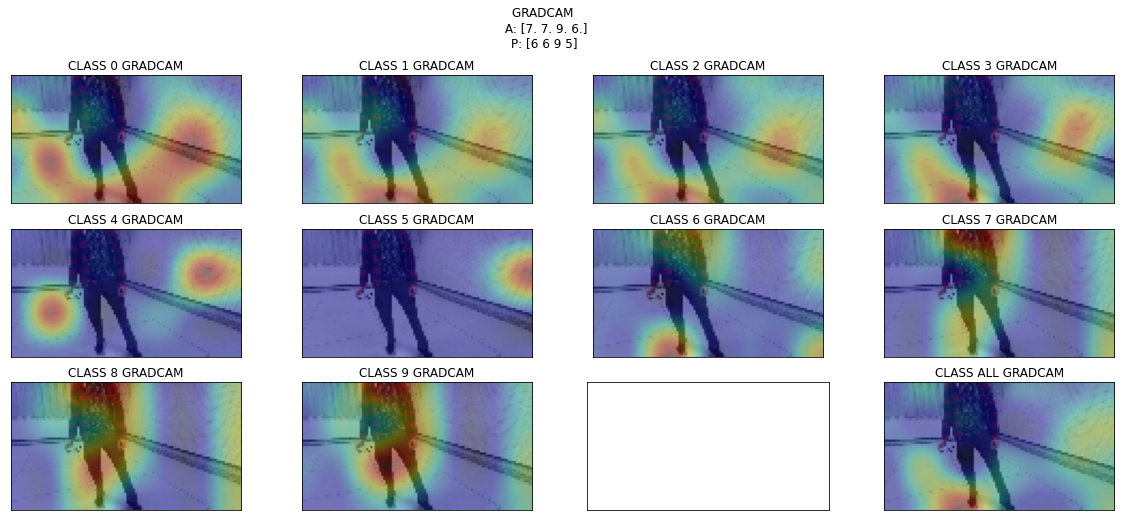

In [ ]:
def perform_gradcam2(gradcam_obj, losses):
  
  if var_index == None:
    aa = str(y_train[vis_idx[0],4:8])
    pp = str(img_class_pred[0])
  else: # single variable
    aa = int(y_train[vis_idx[0],var_index])
    pp = img_class_pred[0]

  rowsnum = 3
  colsnum = int(np.ceil(len(losses)/rowsnum))
  f, ax = plt.subplots(nrows=rowsnum, ncols=colsnum, figsize=(20, 8), subplot_kw={'xticks': [], 'yticks': []})
  f.suptitle('GRADCAM \n A: ' + aa + '\nP: ' + pp, y = 1)

  for i in range(len(losses)):
    if losses[i] == None:
      continue

    cam = gradcam_obj(losses[i], vis_x[0])
    cam = normalize(cam)

    cell = ax[i//colsnum, i%colsnum]
    cell.set_title('CLASS ' + str('ALL' if i == 11 else i) + ' GRADCAM')

    heatmap = np.uint8(cm.jet(cam[0])[..., :3] * 255)
    cell.imshow(vis_img[0])
    cell.imshow(heatmap, cmap='jet', alpha=0.3)



losses = [
  lambda output: K.mean(output[:,0]),
  lambda output: K.mean(output[:,1]),
  lambda output: K.mean(output[:,2]),
  lambda output: K.mean(output[:,3]),
  lambda output: K.mean(output[:,4]),
  lambda output: K.mean(output[:,5]),
  lambda output: K.mean(output[:,6]),
  lambda output: K.mean(output[:,7]),
  lambda output: K.mean(output[:,8]),
  lambda output: K.mean(output[:,9]),
  None,
  lambda output: K.mean(output)
]

gradcam = Gradcam(vis_model, model_modifier)
perform_gradcam2(gradcam, losses)

In [ ]:
# saliency = Saliency(vis_model, model_modifier)
# gradcam = Gradcam(vis_model, model_modifier)

# smooth = 200
# if var_index == None:
#   considered_var = ''
# else:
#   considered_var = ' (' + variables_names[var_index] + ' var)'

# perform_saliency(saliency, 'LOW CLASS SALIENCY' + considered_var, loss_low)
# perform_saliency(saliency, 'LOW CLASS SMOOTHGRAD ' + str(smooth) + considered_var, loss_low, smooth)
# perform_gradcam(gradcam, 'LOW CLASS GRADCAM' + considered_var, loss_low)

# perform_saliency(saliency, 'MEDIUM CLASS SALIENCY' + considered_var, loss_medium)
# perform_saliency(saliency, 'MEDIUM CLASS SMOOTHGRAD ' + str(smooth) + considered_var, loss_medium, smooth)
# perform_gradcam(gradcam, 'MEDIUM CLASS GRADCAM' + considered_var, loss_medium)

# perform_saliency(saliency, 'HIGH CLASS SALIENCY' + considered_var, loss_high)
# perform_saliency(saliency, 'HIGH CLASS SMOOTHGRAD ' + str(smooth) + considered_var, loss_high, smooth)
# perform_gradcam(gradcam, 'HIGH CLASS GRADCAM' + considered_var, loss_high)

# perform_saliency(saliency, 'ALL CLASSES SALIENCY' + considered_var, loss_total)
# perform_saliency(saliency, 'ALL CLASSES SMOOTHGRAD ' + str(smooth) + considered_var, loss_total, smooth)